### Clustering 3k PBMCs

The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics (here from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). 

On a terminal, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [1]:
# on a terminal you can download this real world data
# !mkdir pbmc_data
# !wget "http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz" -O pbmc_data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd pbmc_data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir processed_data


In [2]:
import pandas as pd
import scanpy as sc
from pathlib import Path

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300 # resolution to save figures

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams
rcParams["pdf.fonttype"] = 42

import warnings
warnings.filterwarnings('ignore')

sc.settings.verbosity = 0  # reduce the verbosity

# set seed for reproducibility
random_state = 7

sc.logging.print_header()

scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.11


### Directories for loading data and saving data
Start by precising the paths of the data to load and where to save the results

In [3]:
DIR2LOAD = Path("/data/BCI-CRC/nasrine/teaching/pbmc_data/") # directory to load downloaded data 

DIR2SAVE = DIR2LOAD.joinpath("processed_data/")
DIR2SAVE.mkdir(parents=True, exist_ok=True) # create directory for results

FIG2SAVE = DIR2SAVE.joinpath("figures/") # create figures folder to store plots 
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: .h5ad.

In [4]:
adata = sc.read_10x_mtx(
    DIR2LOAD.joinpath("filtered_gene_bc_matrices/hg19/"),  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

See [anndata-tutorials/getting-started](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html)
for a more comprehensive introduction to AnnData.

In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

### Initial processing

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

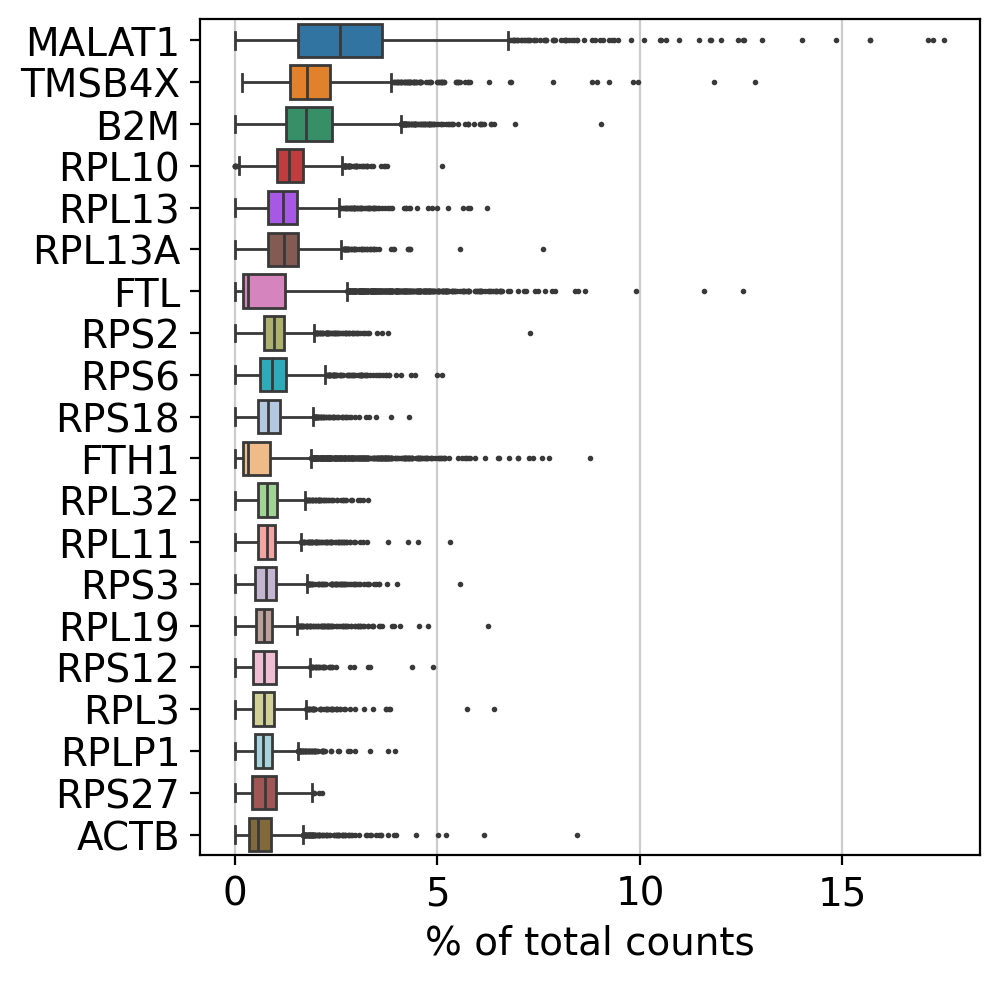

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

### Quality control

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [8]:
# find genes that are mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# find genes that are ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

# compute QC metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=False, percent_top=None
)

In [9]:
adata.obs[
        ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"]
    ].describe()

n_genes_by_counts  total_counts  pct_counts_mt  pct_counts_ribo
count        2700.000000   2700.000000    2700.000000      2700.000000
mean          846.994074   2366.900391       2.215132        34.949211
std           282.104964   1094.262085       1.165438        10.215296
min           212.000000    548.000000       0.000000         1.055966
25%           690.000000   1757.750000       1.536238        26.332963
50%           817.000000   2197.000000       2.029639        36.769516
75%           953.250000   2763.000000       2.640218        43.353328
max          3422.000000  15844.000000      22.569027        59.441711

In [10]:
adata.var.describe()

n_cells_by_counts   mean_counts  pct_dropout_by_counts   total_counts
count       32738.000000  32738.000000           32738.000000   32738.000000
mean           69.854114      0.072298              97.412811     195.205292
std           238.263898      0.852401               8.824589    2301.482666
min             0.000000      0.000000               0.000000       0.000000
25%             0.000000      0.000000              98.703704       0.000000
50%             1.000000      0.000370              99.962963       1.000000
75%            35.000000      0.013704             100.000000      37.000000
max          2700.000000     59.883335             100.000000  161685.000000

A violin plot of some of the computed quality measures:

   * the number of genes expressed in the count matrix
   * the total counts per cell
   * the percentage of counts in mitochondrial genes


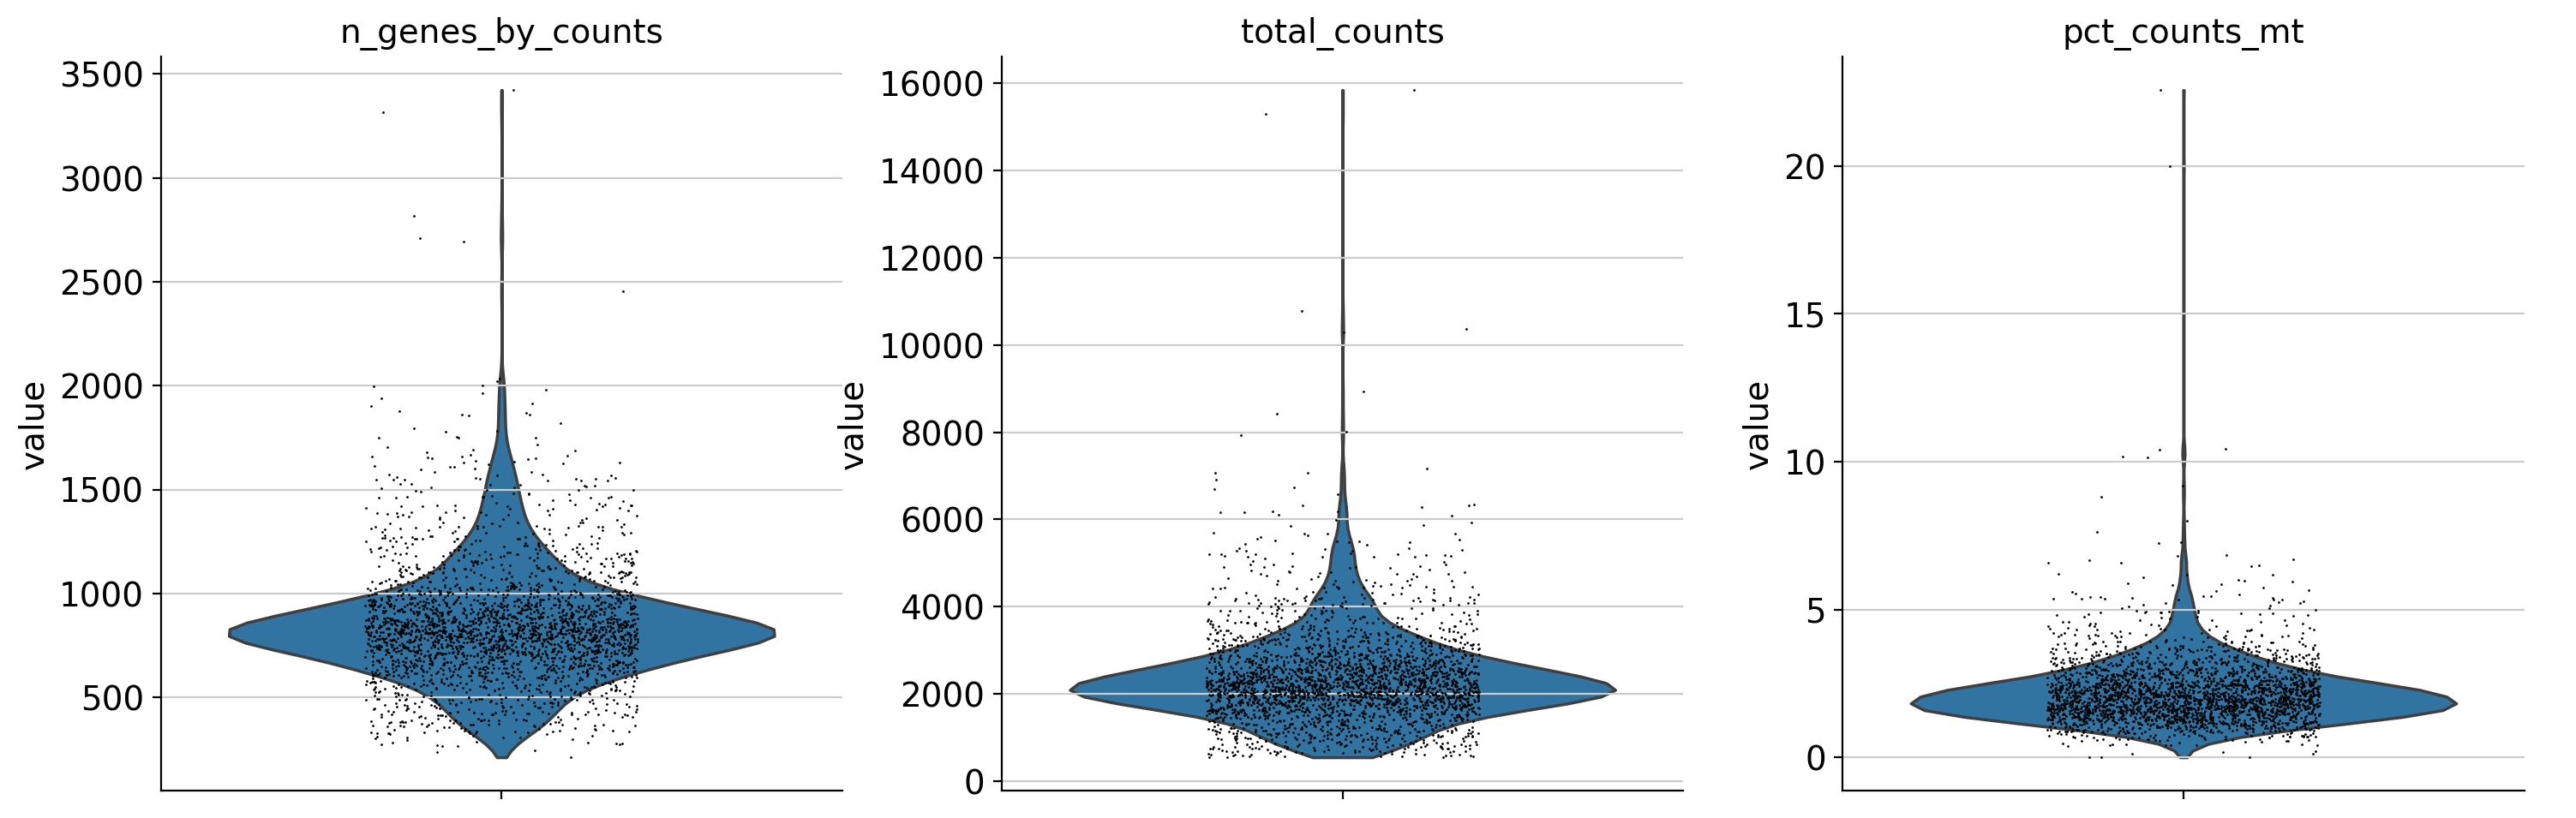

In [11]:
# violin plot of some distributions
sc.pl.violin(
    adata,
    keys=["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.2,
    multi_panel=True,
    rotation=30,
    save="QC_covariates.pdf",
    show=True,
)

#### Filter cells according to identified QC thresholds:

* set threshold MT percent to 20%
* remove ribosomal and mitochondrial genes 
* remove cells with less than 300 genes

In [12]:
#### Filter cells according to identified QC thresholds:
print("Total number of cells: {:d}".format(adata.n_obs))

# remove cells with more than 20% MT genes
adata = adata[adata.obs.pct_counts_mt < 20, :].copy()
print("Number of cells after mt filter: {:d}".format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes=300)
print("Number of cells after gene filter: {:d}".format(adata.n_obs))

Total number of cells: 2700
Number of cells after mt filter: 2698
Number of cells after gene filter: 2683


#### Remove mt and ribo genes

In [13]:
print(adata.shape[1])
adata = adata[:, ~adata.var["mt"].values]
print("After mt genes removal: ", adata.shape[1])
adata = adata[:, ~adata.var["ribo"].values]
print("After ribo genes removal: ", adata.shape[1])

32738
After mt genes removal:  32725
After ribo genes removal:  32619


### Normalise + log transform + HVG

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data.


In [14]:
# keep raw
adata.layers["raw"] = adata.X.copy()  # preserve counts

# normalize + log1p
# Total-count normalize (library-size correct) the data matrix
# to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)
adata.layers["normalised"] = adata.X.copy()
# Logarithmize the data
sc.pp.log1p(adata)

adata.layers["log1p"] = adata.X.copy()

adata.raw = adata  # keep normalised log1p

The count data has been normalized and log-transforme d with an offset of 1. The latter is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros. We keep this data in the '.raw' part of the AnnData object as it will be used to visualize gene expression and perform statistical tests such as computing marker genes for clusters.

**Notice** that we set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

### HVG 
We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

**Expects logarithmized data, except when `flavor='seurat_v3'` in which
count data is expected.**

In [15]:
sc.pp.highly_variable_genes(
    adata,
    subset=True,  # subset for integration (but full lognorm data in .raw)
    layer="raw",
    flavor="seurat_v3",
    n_top_genes=2000,
    span=0.3,
    min_disp=0.5,
    min_mean=0.0125,
    max_mean=3,
)

The result of the previous highly-variable-genes detection is stored as an annotation in .var.highly_variable and auto-detected by PCA and hence, sc.pp.neighbors and subsequent manifold/graph tools.

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [16]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [17]:
sc.pp.scale(adata, max_value=10)

### Dimensionality reduction with PCA (Principal Component Analysis)
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering functions `sc.tl.louvain/leiden()`. In our experience, often a rough estimate of the number of PCs does fine.

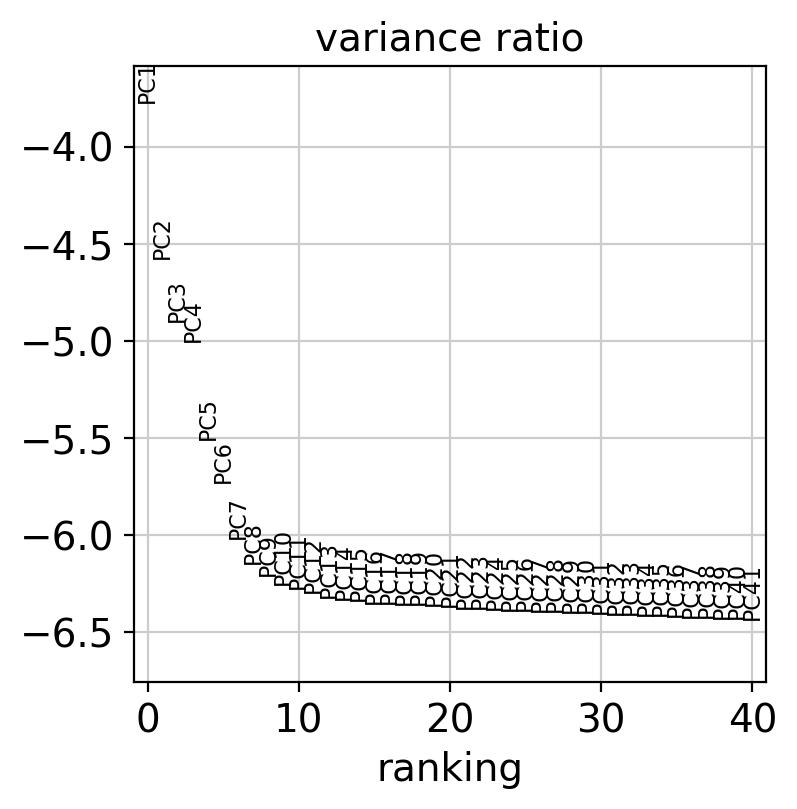

In [18]:
# perform PCA on adata_liver (which contains only HVG (after normalized, log1p) and scaled
sc.tl.pca(adata, svd_solver="arpack", use_highly_variable=True, random_state=random_state)


# Elbow plot to look at number of PCs
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=40, show=True)

### Computing the neighborhood graph
Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. 

Nb of neighbours depends on the size of the dataset (usually can get away with using 15 neighbours) Here since the data size is small we go with 10. We pick 40 PCs, but we could have picked 10-15 and that would have been fine (it's at the elbow).

In [19]:
# compute neighbourhood graph
sc.pp.neighbors(
    adata,
    n_neighbors=10,
    n_pcs=40,#15,
    knn=True,
    method="umap",
    metric="euclidean",
    random_state=random_state,
)

### Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. 

In [20]:
# compute UMAP embedding
sc.tl.umap(adata, min_dist=0.3, n_components=2, random_state=random_state)

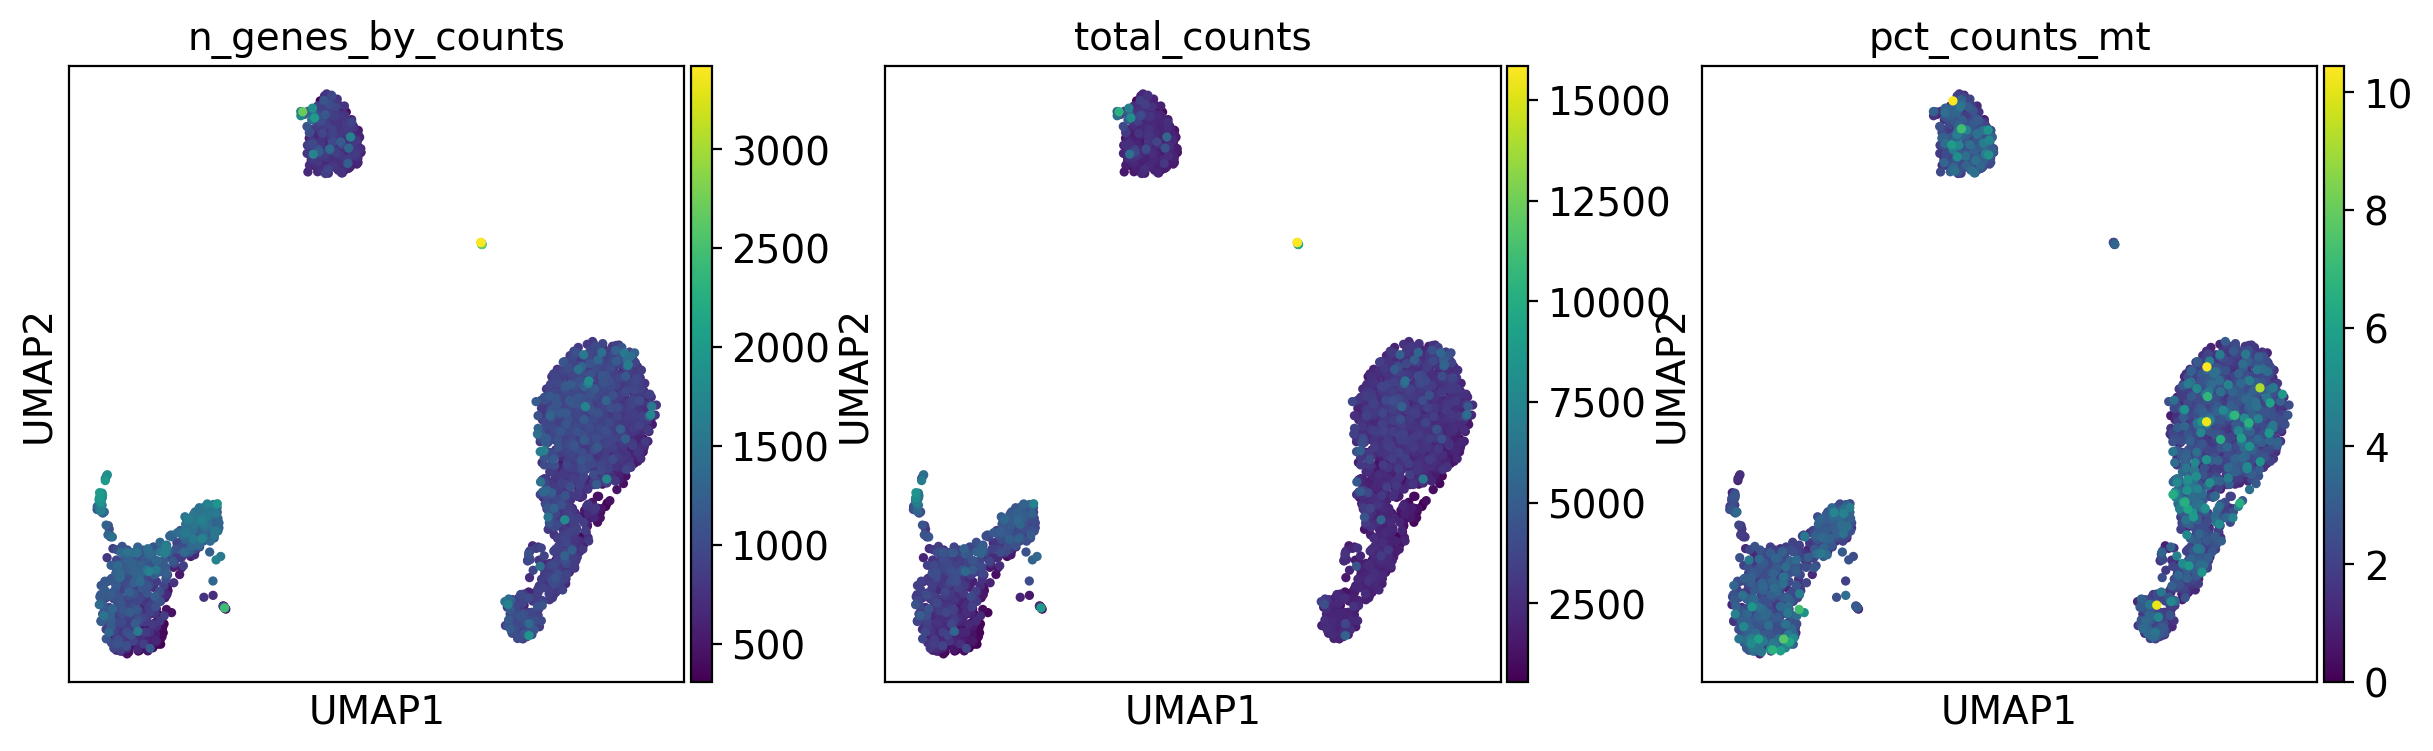

In [21]:
sc.pl.umap(adata, color=["n_genes_by_counts", "total_counts", "pct_counts_mt"], cmap="viridis")

### Clustering the neighborhood graph
We recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag et al. (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [22]:
sc.tl.leiden(
    adata,
    resolution=0.9,#0.6,
    n_iterations=2,
    directed=False,
    random_state=random_state,
    key_added='leiden'
)

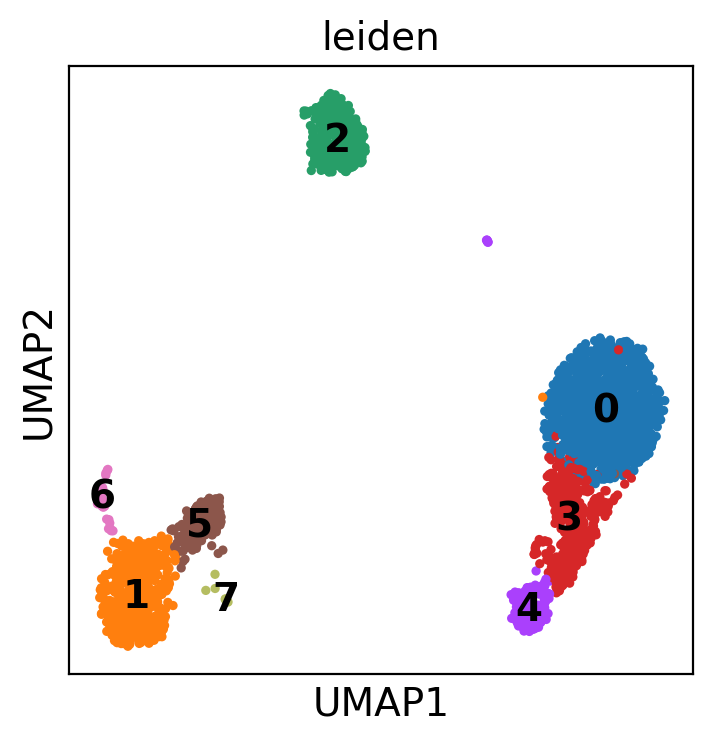

In [23]:
# Plot the clusters 
sc.pl.umap(
    adata,
    color="leiden",
    legend_loc="on data",
    save="clustering.pdf",
    show=True,
)

In [24]:
adata

AnnData object with n_obs × n_vars = 2683 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'leiden'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'normalised', 'log1p'
    obsp: 'distances', 'connectivities'

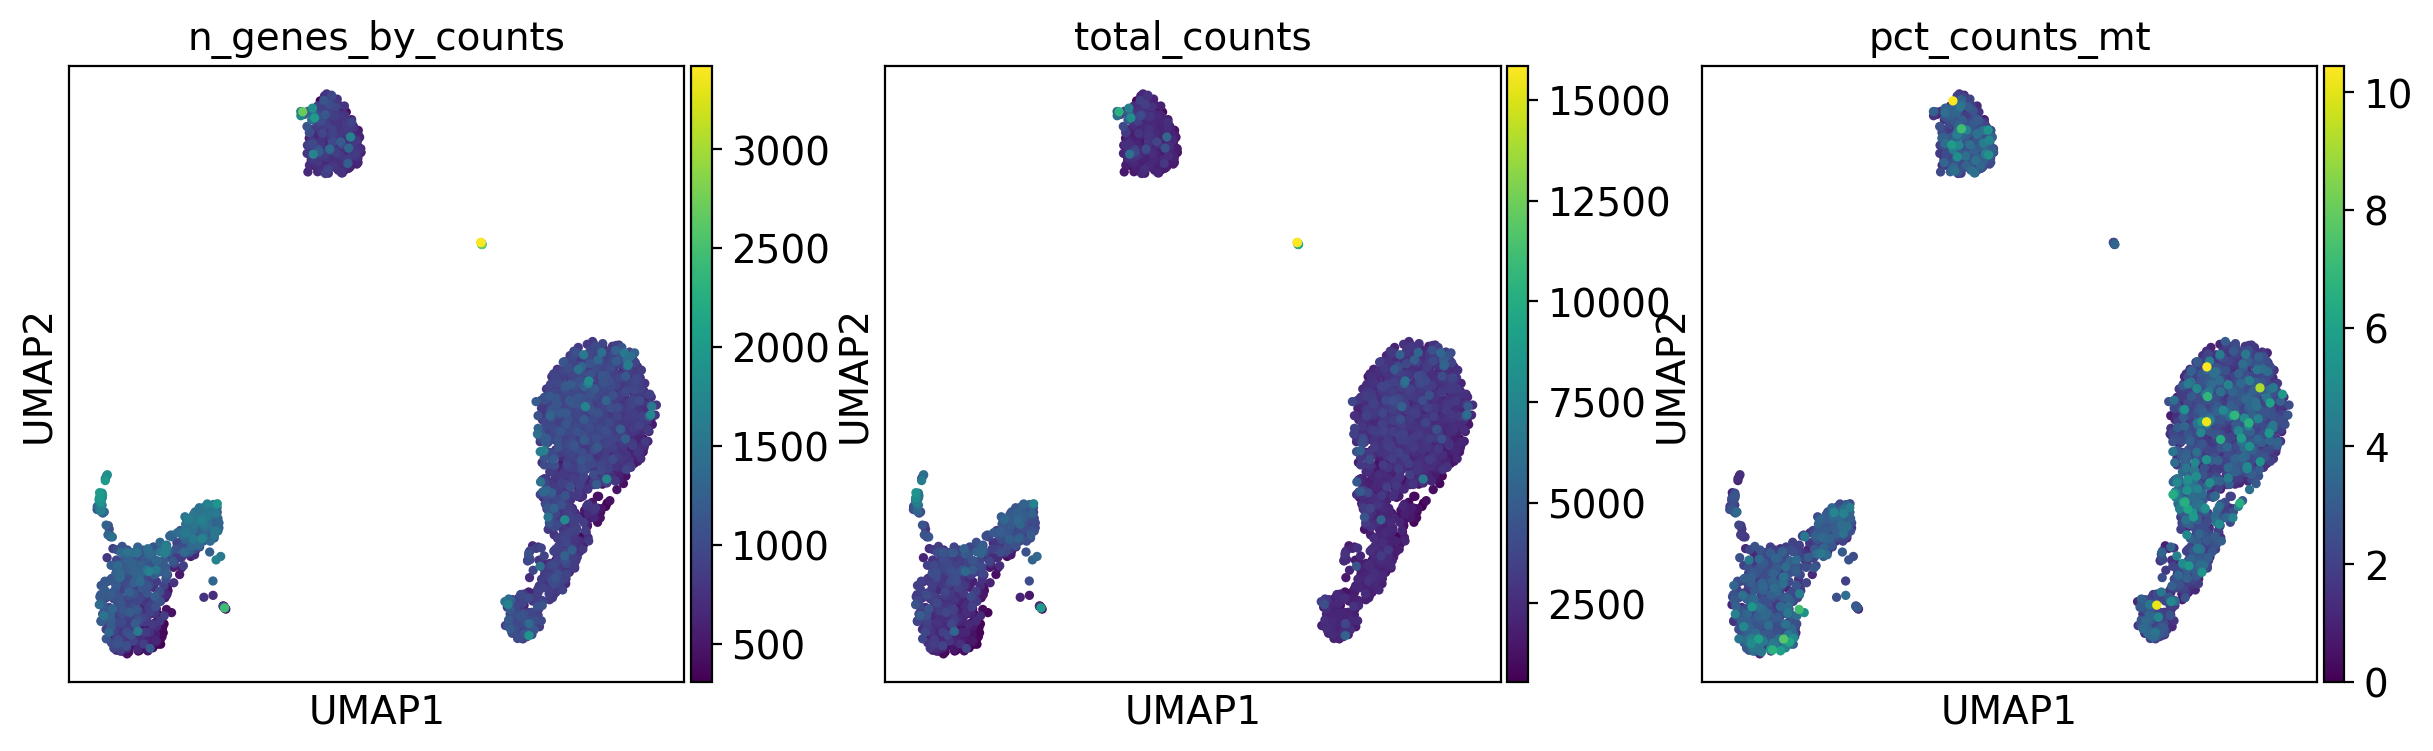

In [25]:
sc.pl.umap(adata, color=["n_genes_by_counts", "total_counts", "pct_counts_mt"], cmap="viridis")

### Finding markers for cluster annotation

Differential expression to get DE genes upregulated per cluster : Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before.

In [26]:
sc.tl.rank_genes_groups(
    adata,
    groupby="leiden",
    reference="rest",
    method="wilcoxon",
    use_raw=True,
    layer=None,
    pts=True,
    corr_method="benjamini-hochberg",
    key_added="rank_genes_wilcoxon",
)

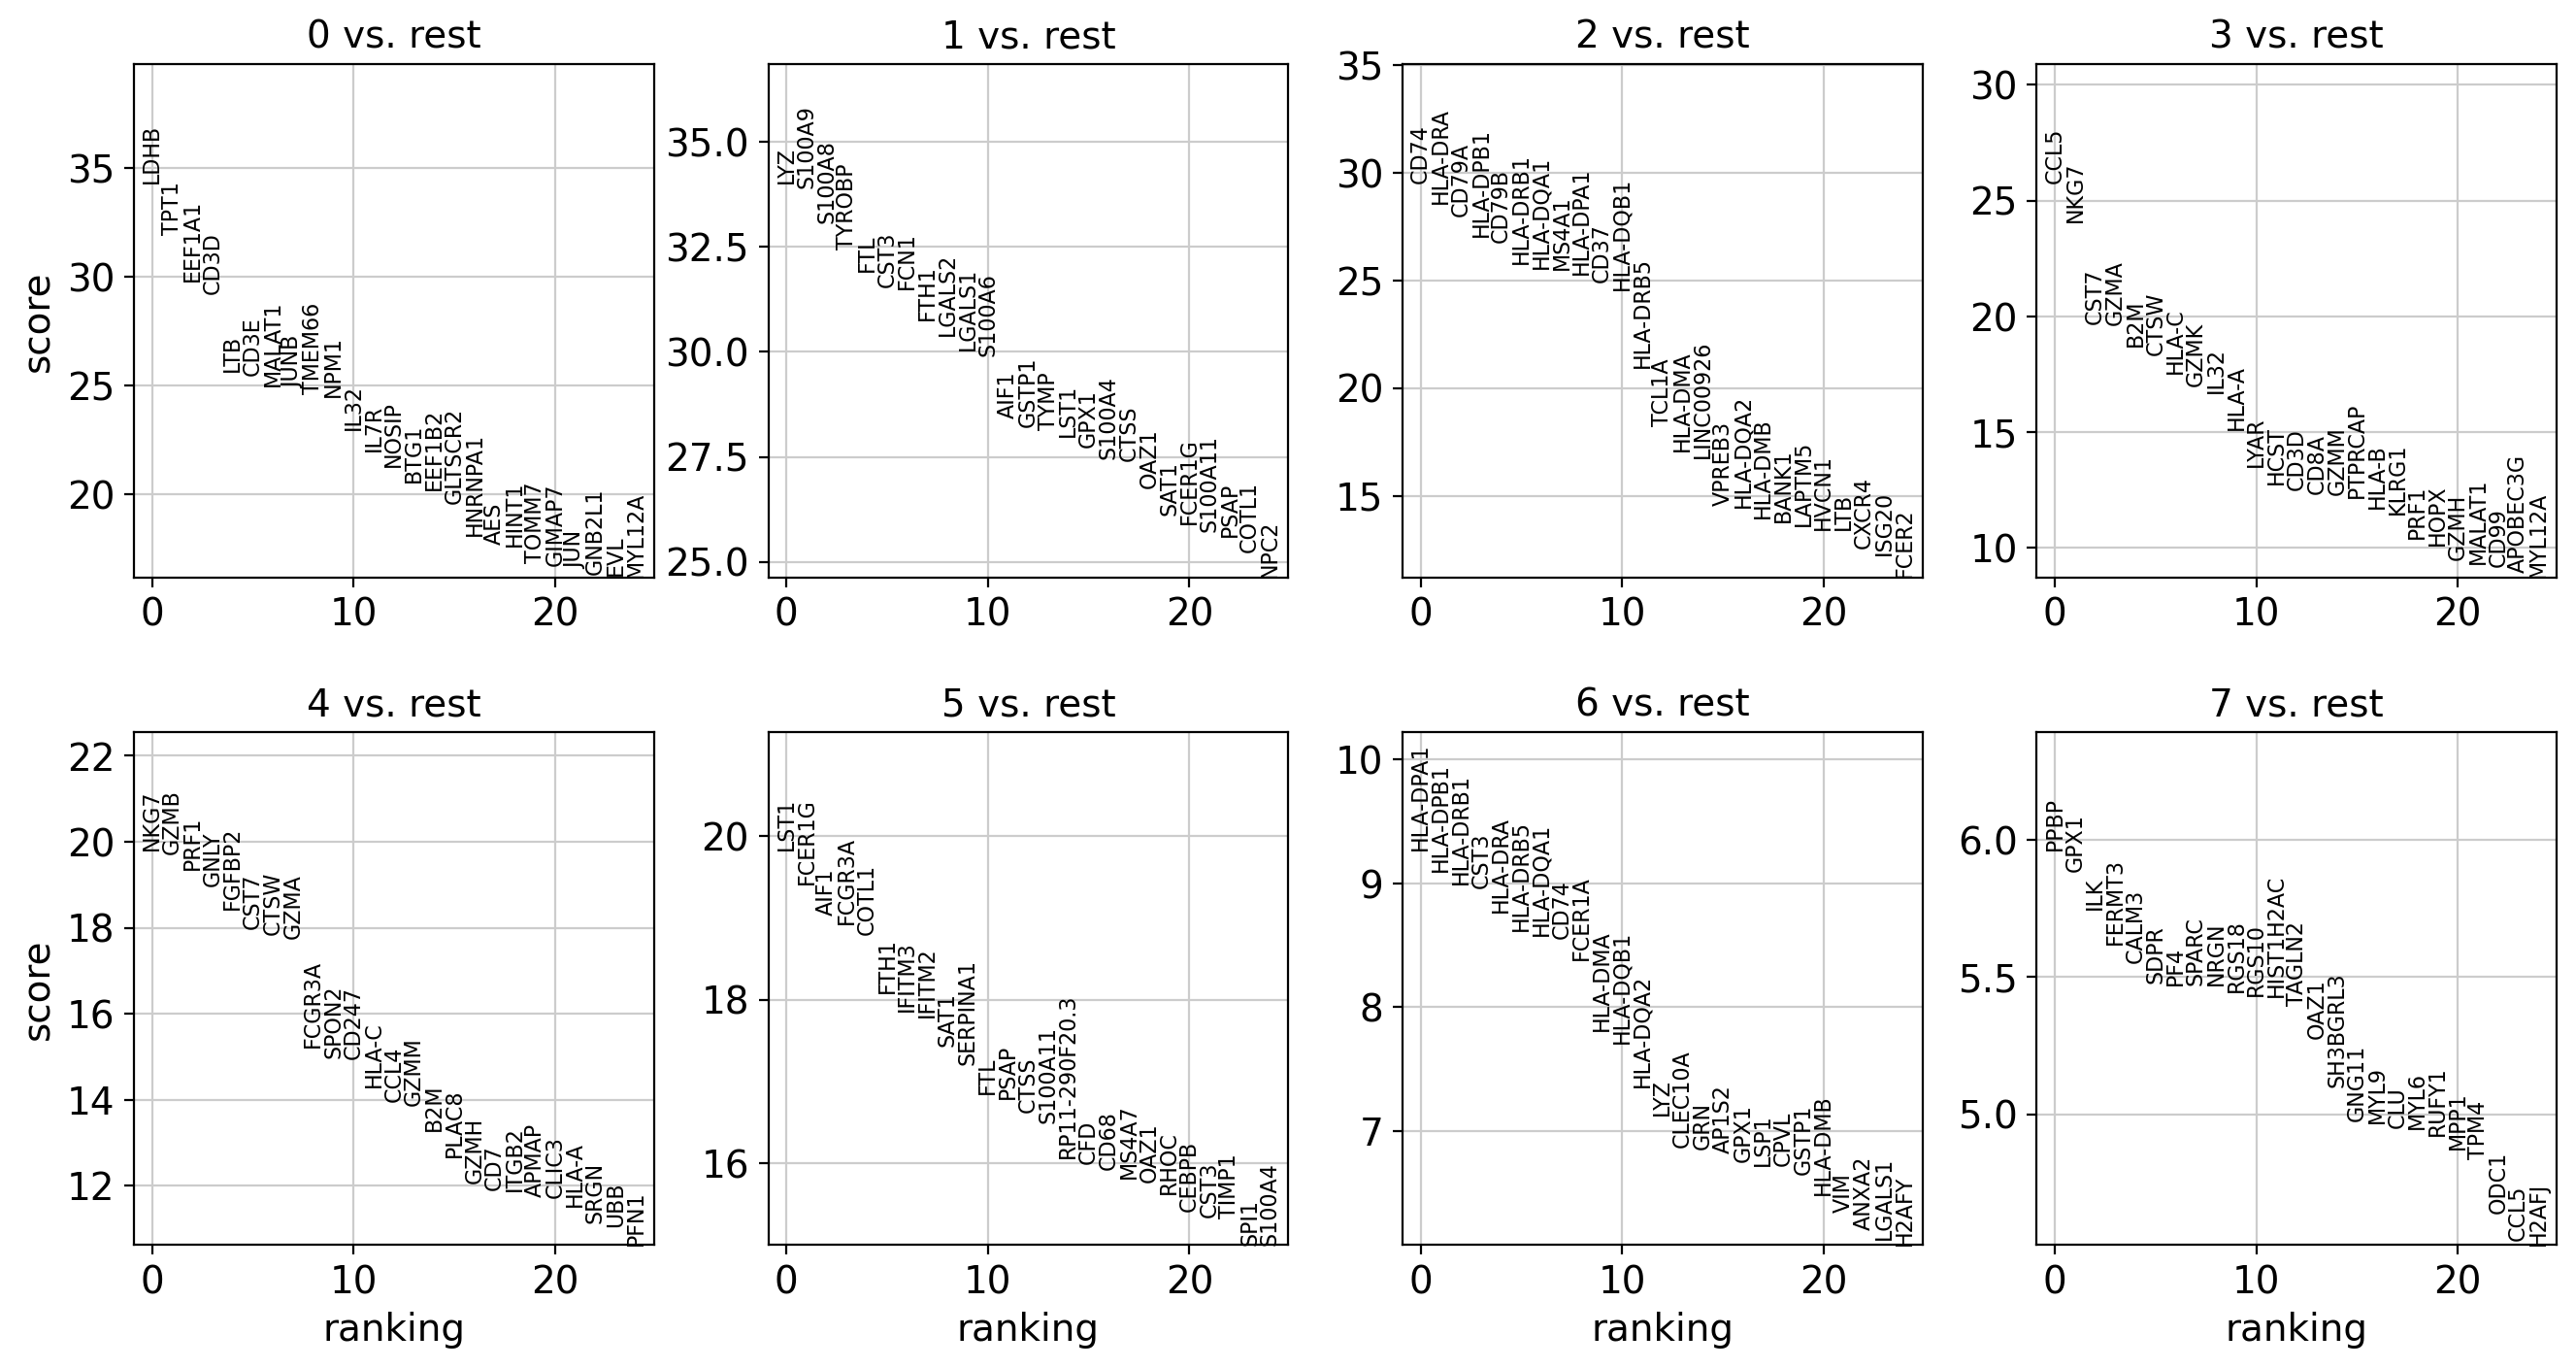

In [27]:
sc.pl.rank_genes_groups(adata, n_genes=25, key="rank_genes_wilcoxon", sharey=False)

In [28]:
# let's plot some markers 
markers = {
    "Megakaryocyte": ["PPBP"],
    "T": ["CD3D", "CD3E", "CD3G", "KLRB1", "GZMB"],
    "CD4 T": ["CD4"],
    "CD8 T": ["CD8A", "CD8B"],
    "NK": ["NCR1", "NCAM1", "KLRC1"],
    "B": ["CD79A", "MS4A1"],
    "Myeloid": ["CD68", "CD14", "LYZ"],
    "Monocyte": ["S100A8", "S100A9", "VCAN", "FCN1"],
    "CD14 Monocyte": ["CD14"],
    "CD16 Monocyte": ["FCGR3A"],
    "DC": ["FCER1A", "PKIB", "CD1C", "CLEC10A"],
    
}

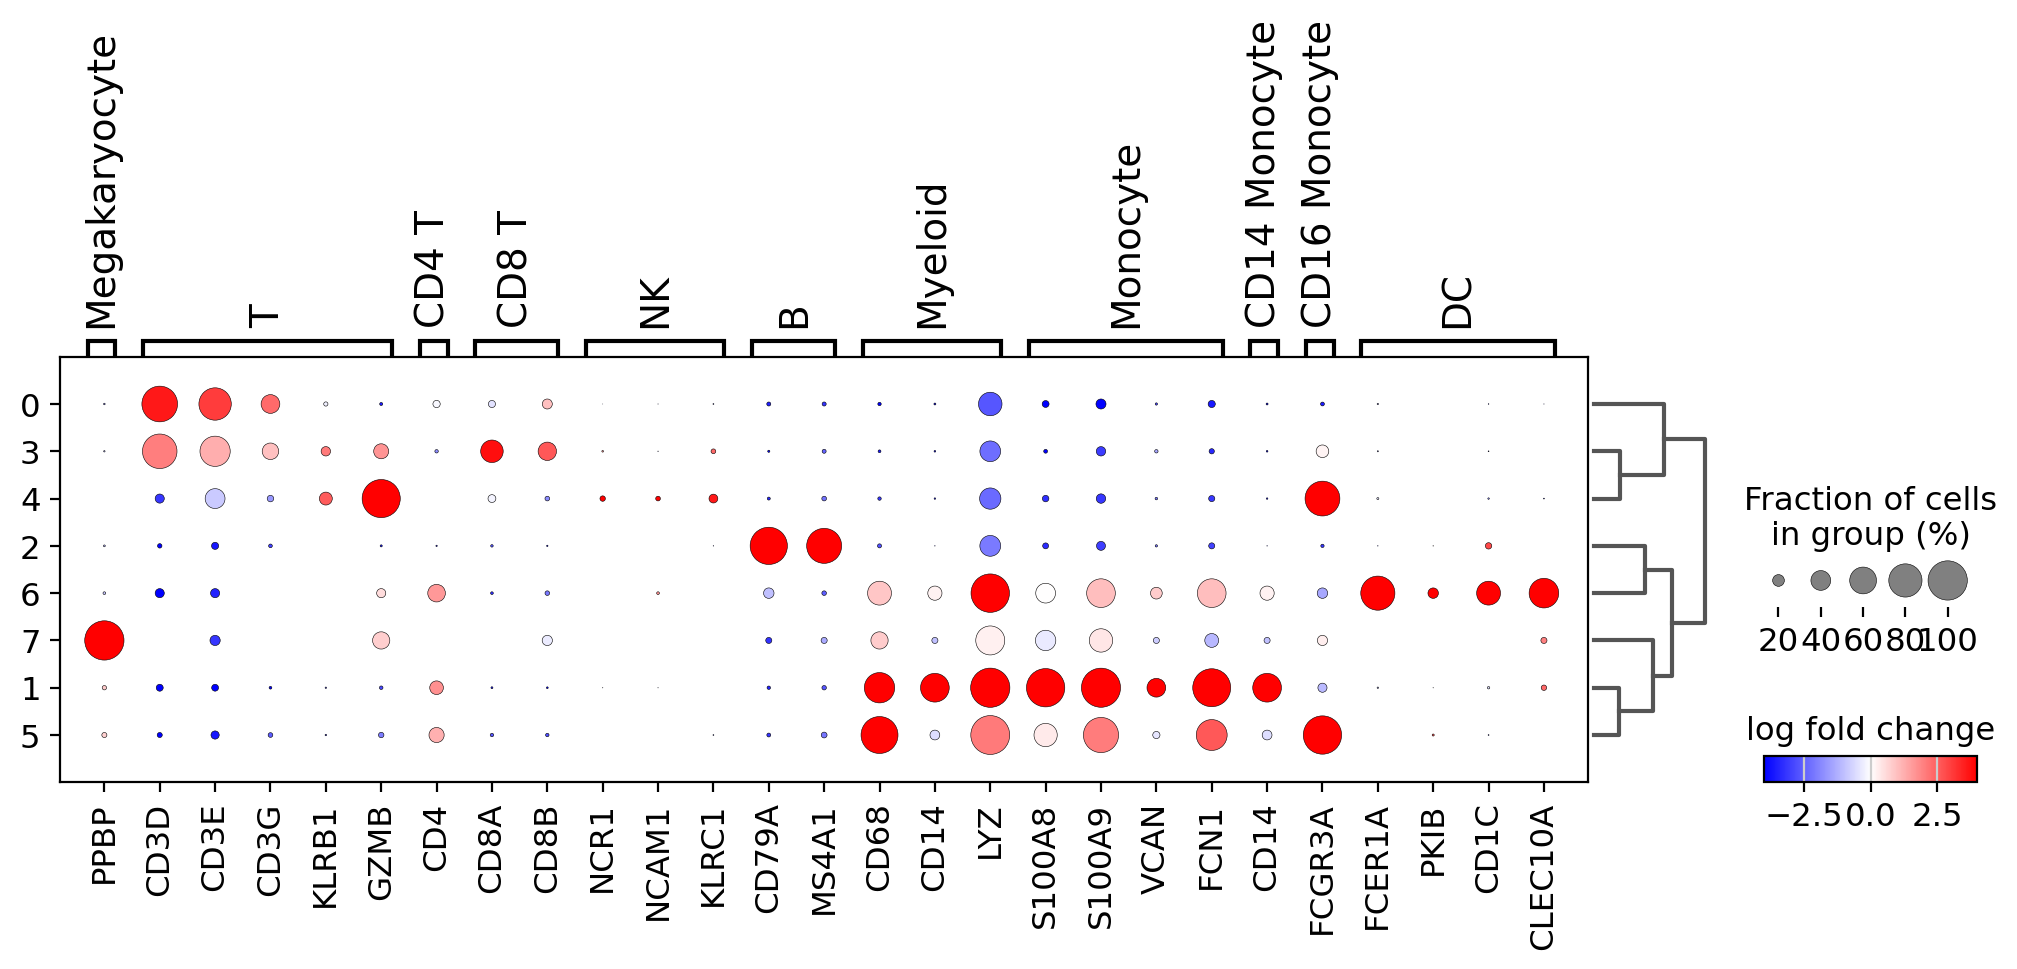

In [29]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby="leiden",
    key="rank_genes_wilcoxon",
    var_names=markers,
    values_to_plot="logfoldchanges",
    cmap="bwr",
    vmin=-4,
    vmax=4,
    min_logfoldchange=1,
    colorbar_title="log fold change",
    save="marker_dotplot.pdf",
    show=True,
)

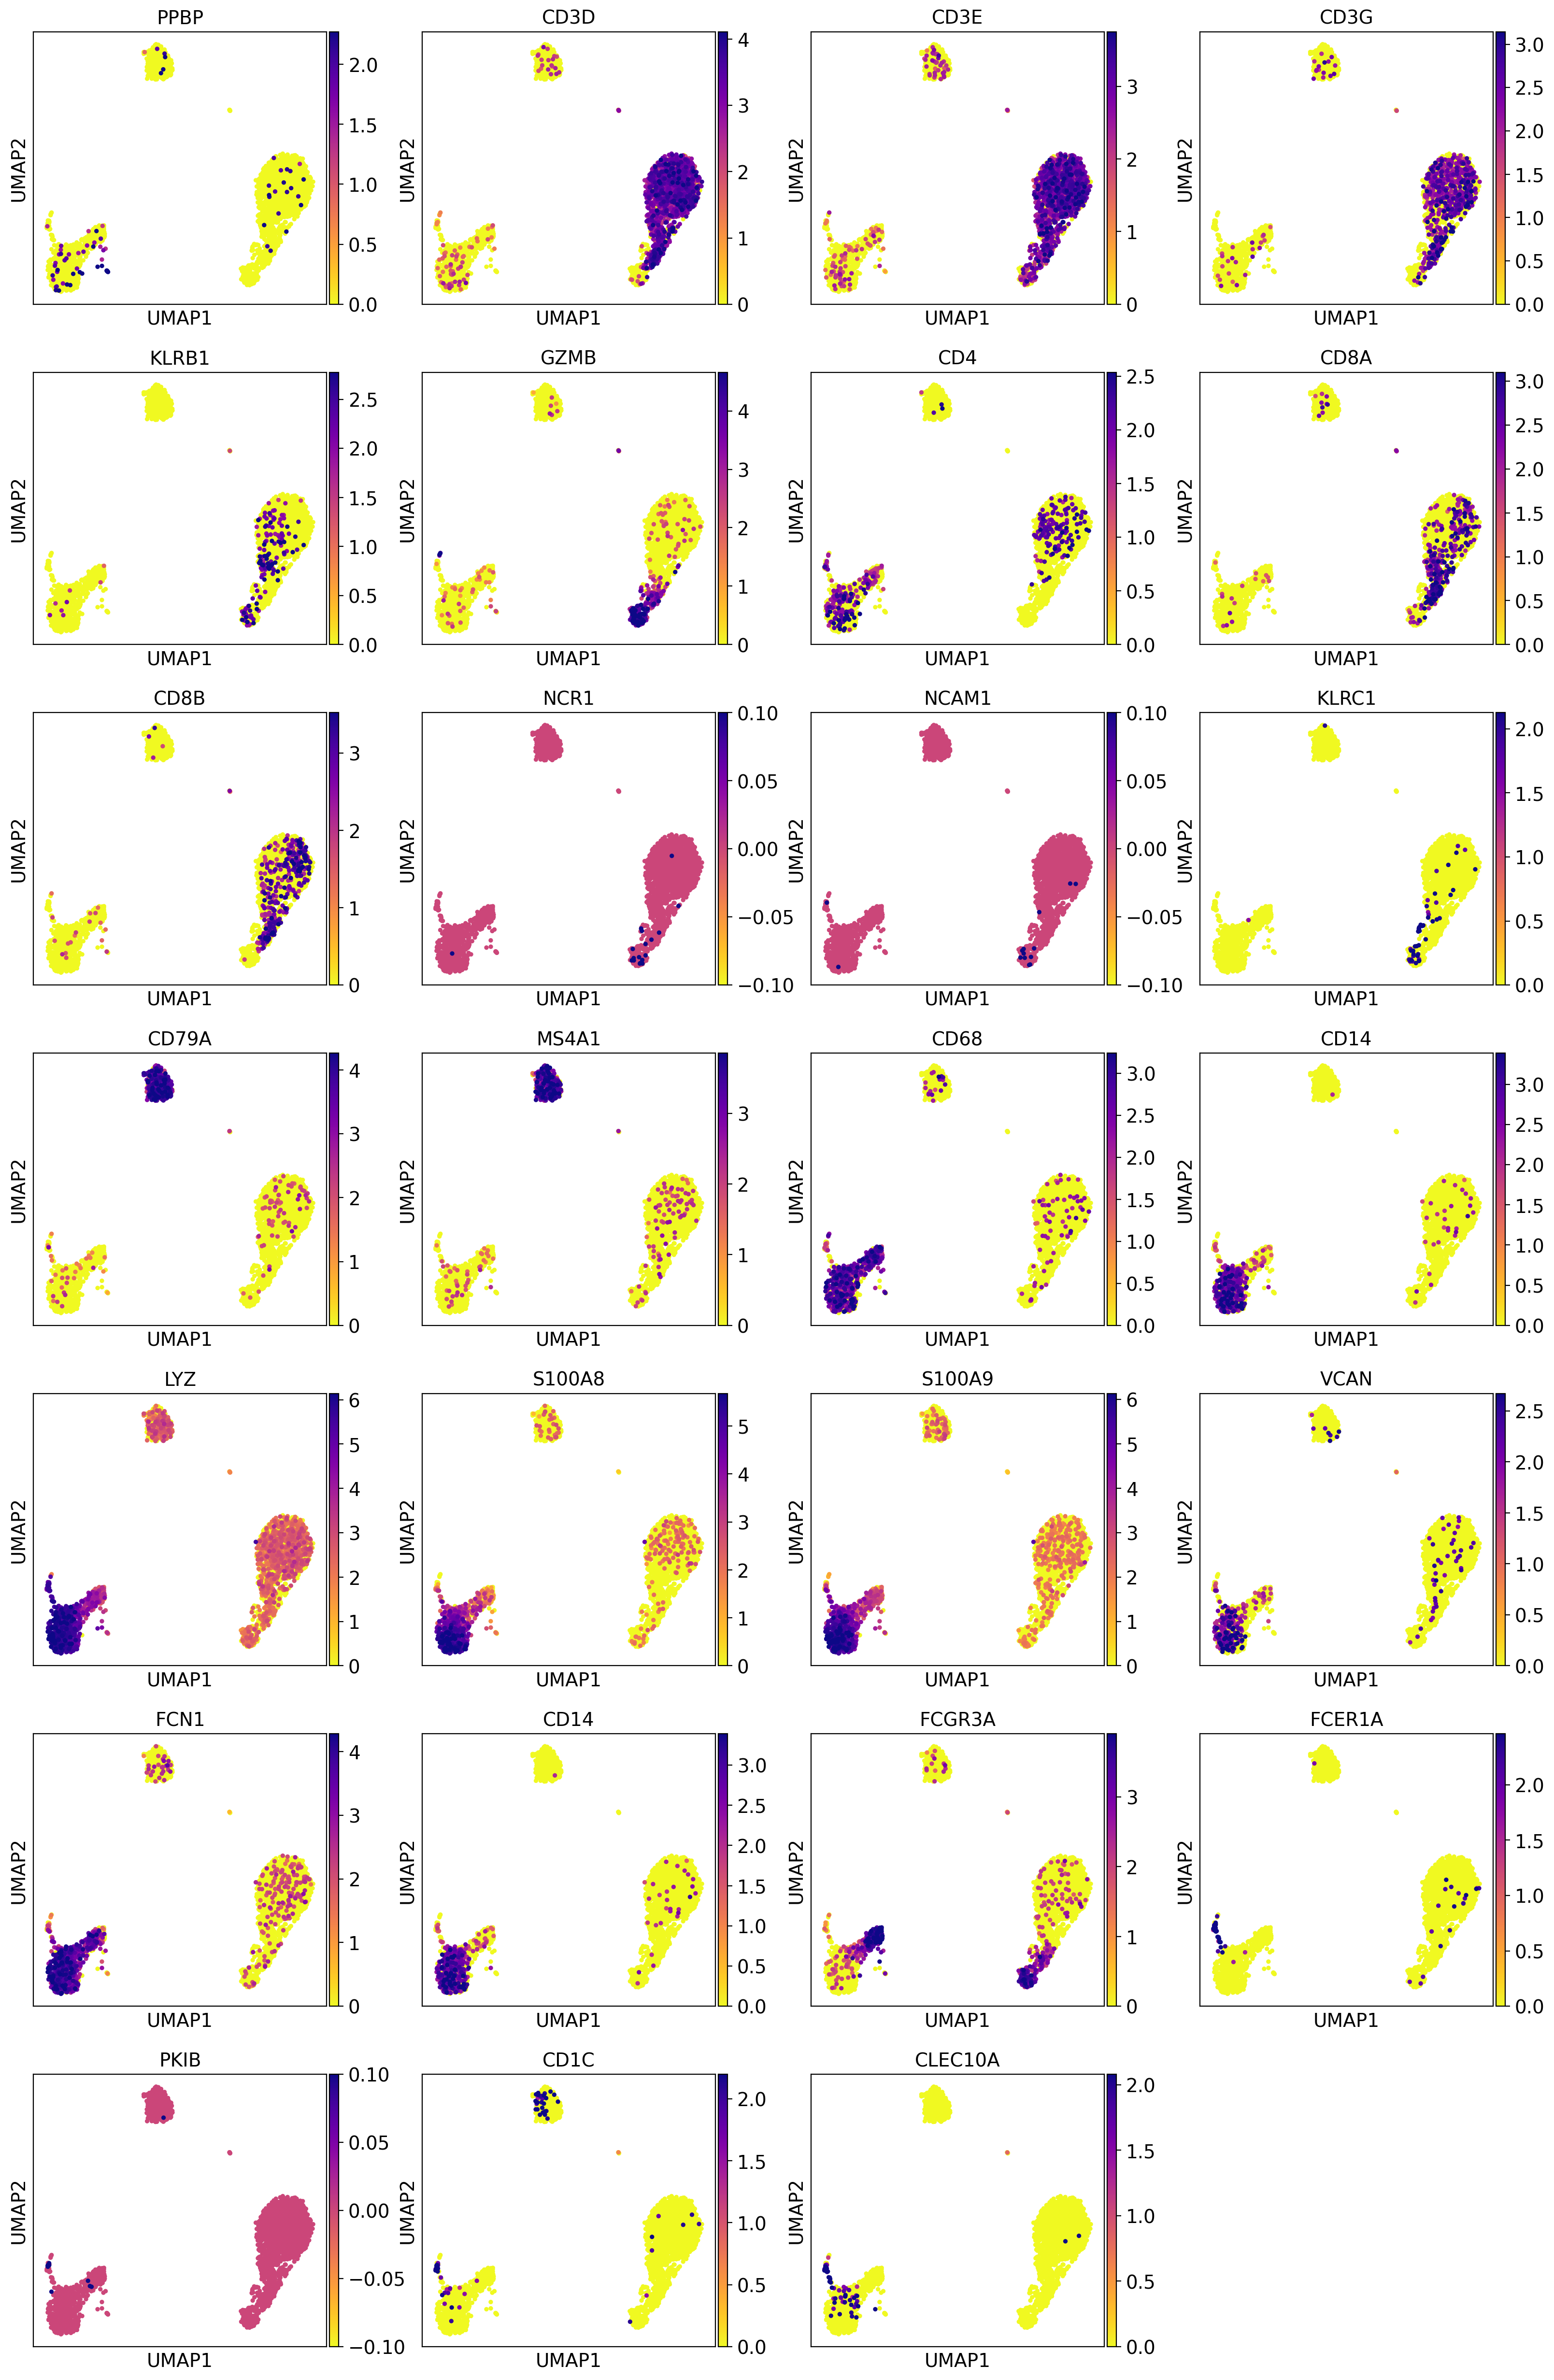

In [30]:
## we can also see them on the umap coordinates
import itertools
# use log1p data stored in .raw
markers2plot = list(
    itertools.chain(*list(markers.values()))
)  # get all markers in a single list
sc.pl.umap(
    adata,
    color=markers2plot,
    use_raw=True,
    vmin=0.0,
    vmax="p99",
    color_map="plasma_r",  #'RdPu',
    save="markers.pdf",
    show=True,
)

### save an excel file with marker genes in each cluster 
very useful to have a look at the upregulated genes in each cluster

In [ ]:
pval_thresh = 0.05
log2fc_thresh = 1
cluster_de_genes = dict()
for cluster in sorted(set(adata.obs["leiden"])):
    cluster_de_genes[cluster] = sc.get.rank_genes_groups_df(
        adata,
        group=cluster,
        key="rank_genes_wilcoxon",
        pval_cutoff=pval_thresh,
        log2fc_min=log2fc_thresh,
        log2fc_max=None,
    ).sort_values("logfoldchanges", ascending=False)

# write to excel file DE genes per cluster
# Create a Pandas Excel writer using XlsxWriter as the engine.
path2save = DIR2SAVE.joinpath(
    "pbmc3k_general_clustering_pval{}_log2fc{}.xlsx".format(pval_thresh, log2fc_thresh)
)

with pd.ExcelWriter(path2save) as writer:
    for cluster in list(cluster_de_genes.keys()):

        # get celltype of cluster
        # celltype = np.unique(adata[adata.obs['leiden']==cluster,:].obs['cell identity'])[0]

        cluster_de_genes[cluster].to_excel(
            writer, sheet_name="cluster{}".format(cluster)
        )

### Clustering annotation

from looking at marker genes we can see that it is quite easy to annotate the clusters

if res = 0.6 and PCs = 15
* 0:  CD4 T cell
* 1:  CD8 T cell
* 2:  CD14 Monocyte
* 3:  B cell
* 4:  CD8 T cell
* 5:  CD16 Monocyte # Megakaryocyte
* 6:  NK cell
* 7:  DC

if res = 0.9 and PCs = 40
* 0:  CD4 T cell
* 1:  CD14 Monocyte
* 2:  B cell
* 3:  CD8 T cell
* 4:  NK cell
* 5:  CD16 Monocyte # Megakaryocyte
* 6:  DC
* 7:  Megakaryocyte


NK = natural killer, DC = dendritic cell

In [31]:
new_cluster_annotations = {
    "0":  "CD4 T cell",
    "1":  "CD14 Monocyte",
    "2":  "B cell",
    "3":  "CD8 T cell",
    "4":  "NK cell",
    "5":  "CD16 Monocyte", # Megakaryocyte
    "6":  "DC",
    "7":  "Megakaryocyte",
}
adata.obs["Annotation"] = (
    adata.obs["leiden"].map(new_cluster_annotations).astype("category")
)

In [36]:
# set colours for cell types, need to know order
adata.obs.Annotation.cat.categories.values.tolist()

['CD4 T cell',
 'CD14 Monocyte',
 'B cell',
 'CD8 T cell',
 'NK cell',
 'CD16 Monocyte',
 'DC',
 'Megakaryocyte']

In [37]:
# color palette for annotation
pal_dict = {
    "CD4 T cell": "#8DD3C7",
    "CD14 Monocyte": "#F781BF",
    "B cell": "#BEBADA",
    "CD8 T cell": "#FB8072",
    "NK cell": "#B3DE69",
    "CD16 Monocyte": "#FDB462",
    "DC": "#7570B3",
    "Megakaryocyte": "#fccde5"
}

In [38]:
# same order as categories
adata.uns["Annotation_colors"] = list(pal_dict.values())

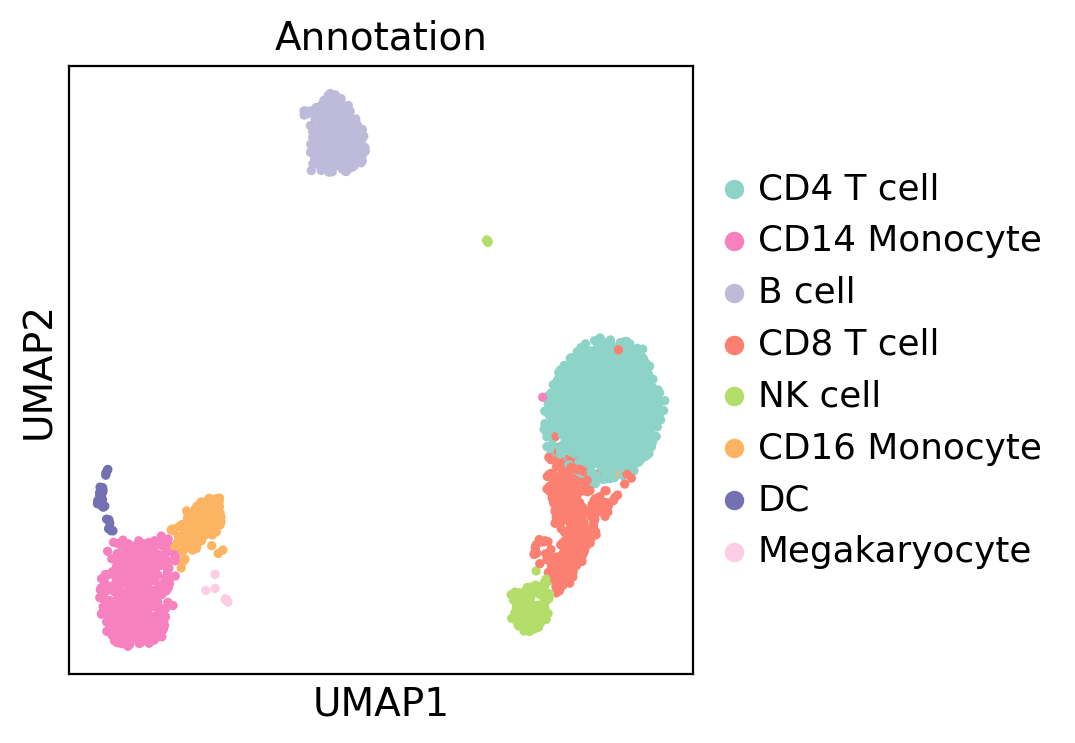

In [39]:
sc.pl.umap(
    adata, color="Annotation", show=True, legend_loc="right margin",
    save="Annotation.pdf",
)

### save results file

In [40]:
# save result
# write to file
adata.write(
    DIR2SAVE.joinpath(
        "pbmc3k_clustering.h5ad"
    )
)